In [1]:
from collections import Counter
import tensorflow as tf
import numpy as np
import cv2
from imgaug import augmenters as iaa

c:\Users\dshra\tugasakhir\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [5]:
import face_recognition
import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

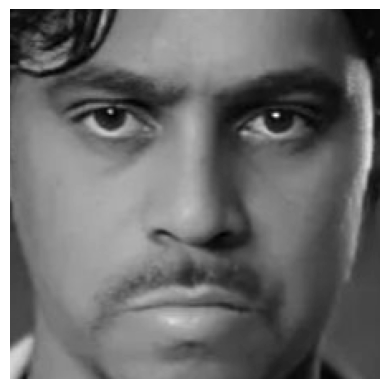

(224, 224)


In [22]:
input_image = face_recognition.load_image_file('./public/fs3.jpg')
face_locations = face_recognition.face_locations(input_image)
top, right, bottom, left = face_locations[0]
face_image = input_image[top:bottom, left:right]
face_image = np.array(Image.fromarray(face_image).resize((224, 224)))

face_image_bw = np.mean(face_image, axis=-1)


plt.imshow(face_image_bw, cmap="gray")  # Use "gray" colormap for black and white
plt.axis("off")
plt.show()

print(face_image_bw.shape)

In [2]:
resnet50 = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet')
modelR = tf.keras.Model(inputs=resnet50.input, outputs=resnet50.get_layer('conv4_block5_out').output)

xception = tf.keras.applications.xception.Xception(include_top=False, weights='imagenet')
modelX = tf.keras.Model(inputs=xception.input, outputs=xception.get_layer('conv2d_2').output)

vgg19 = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
modelV = tf.keras.Model(inputs=vgg19.input, outputs=vgg19.get_layer('block5_conv4').output)

In [3]:
checkpoint_path_R = "./resnet/my_capsule_network"  
checkpoint_path_X = "./xception/my_capsule_network"  
checkpoint_path_V = "./vgg/my_capsule_network"

In [4]:
def preprocess_image(img):
    # Convert the image to a NumPy array
    img_array = np.array(img)

    # Define augmentation sequence
    augmenter = iaa.Sequential([
        iaa.AdditiveGaussianNoise(scale=(0, 0.05 * 255)), 
    ])

    # Apply the augmentation to the image
    img_array = augmenter.augment_image(img_array)

    # Resize the augmented image to a specific size (e.g., 224x224 pixels)
    img_array = cv2.resize(img_array, (224, 224))

    # Perform any other preprocessing steps like normalization (if needed)

    return img_array


In [5]:
tf.compat.v1.disable_eager_execution()
X = tf.compat.v1.placeholder(shape=[None, 14, 14, 1], dtype=tf.float32, name="X") #14, 14

caps1_n_maps = 8 #ku ubah
caps1_n_caps = caps1_n_maps * 10 * 10
caps1_n_dims = 2 

conv1_params = {
    "filters": 64,
    "kernel_size": 3,
    "strides": 1,
    "padding": "valid",
    "activation": tf.nn.relu,
}

conv2_params = {
    "filters": caps1_n_maps * caps1_n_dims,
    "kernel_size": 3,
    "strides": 1,
    "padding": "valid",
    "activation": tf.nn.relu
}

conv1 = tf.compat.v1.layers.conv2d(X, name="conv1", **conv1_params)
conv2 = tf.compat.v1.layers.conv2d(conv1, name="conv2", **conv2_params)

caps1_raw = tf.reshape(conv2, [-1, caps1_n_caps, caps1_n_dims],
                       name="caps1_raw")

def squash(s, axis=-1, epsilon=1e-7, name=None):
    #with tf.name_scope(name, default_name="squash"):
    with tf.name_scope(name):
        #squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
        #                             keep_dims=True)
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keepdims=True)
        safe_norm = tf.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
        return squash_factor * unit_vector
    
caps1_output = squash(caps1_raw, name="caps1_output")

caps2_n_caps = 2 #ini kuubah
caps2_n_dims = 16

init_sigma = 0.1

#W_init = tf.random_normal(
W_init = tf.random.normal(
    shape=(1, caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims),
    stddev=init_sigma, dtype=tf.float32, name="W_init")
W = tf.Variable(W_init, name="W")

batch_size = tf.shape(X)[0]
W_tiled = tf.tile(W, [batch_size, 1, 1, 1, 1], name="W_tiled") #1

caps1_output_expanded = tf.expand_dims(caps1_output, -1,
                                       name="caps1_output_expanded")
caps1_output_tile = tf.expand_dims(caps1_output_expanded, 2,
                                   name="caps1_output_tile")
caps1_output_tiled = tf.tile(caps1_output_tile, [1, 1, caps2_n_caps, 1, 1],
                             name="caps1_output_tiled") #1

caps2_predicted = tf.matmul(W_tiled, caps1_output_tiled,
                            name="caps2_predicted")

raw_weights = tf.zeros([batch_size, caps1_n_caps, caps2_n_caps, 1, 1],
                       dtype=np.float32, name="raw_weights")

routing_weights = tf.nn.softmax(raw_weights, name="routing_weights")

weighted_predictions = tf.multiply(routing_weights, caps2_predicted,
                                   name="weighted_predictions")
weighted_sum = tf.reduce_sum(weighted_predictions, axis=1, keepdims=True,
                             name="weighted_sum")
caps2_output_round_1 = squash(weighted_sum, axis=-2,
                              name="caps2_output_round_1")

caps2_output_round_1_tiled = tf.tile(
    caps2_output_round_1, [1, caps1_n_caps, 1, 1, 1],
    name="caps2_output_round_1_tiled")

agreement = tf.matmul(caps2_predicted, caps2_output_round_1_tiled,
                      transpose_a=True, name="agreement")

raw_weights_round_2 = tf.add(raw_weights, agreement,
                             name="raw_weights_round_2")
routing_weights_round_2 = tf.nn.softmax(raw_weights_round_2,
                                        name="routing_weights_round_2")
weighted_predictions_round_2 = tf.multiply(routing_weights_round_2,
                                           caps2_predicted,
                                           name="weighted_predictions_round_2")
weighted_sum_round_2 = tf.reduce_sum(weighted_predictions_round_2,
                                     axis=1, keepdims=True,
                                     name="weighted_sum_round_2")
caps2_output_round_2 = squash(weighted_sum_round_2,
                              axis=-2,
                              name="caps2_output_round_2")

caps2_output = caps2_output_round_2

def condition(input, counter):
    return tf.less(counter, 100) #100

def loop_body(input, counter):
    output = tf.add(input, tf.square(counter))
    return output, tf.add(counter, 1)

with tf.name_scope("compute_sum_of_squares"):
    counter = tf.constant(1)
    sum_of_squares = tf.constant(0)

    result = tf.while_loop(condition, loop_body, [sum_of_squares, counter])


with tf.compat.v1.Session() as sess:
    print(sess.run(result))

def safe_norm(s, axis=-1, epsilon=1e-7, keep_dims=False, name=None):
    with tf.name_scope(name):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keepdims=keep_dims)
        return tf.sqrt(squared_norm + epsilon)
    
y_proba = safe_norm(caps2_output, axis=-2, name="y_proba")

y_proba_argmax = tf.argmax(y_proba, axis=2, name="y_proba")

y_pred = tf.squeeze(y_proba_argmax, axis=[1,2], name="y_pred")

y = tf.compat.v1.placeholder(shape=[None], dtype=tf.int64, name="y")

m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5

T = tf.one_hot(y, depth=caps2_n_caps, name="T")

caps2_output_norm = safe_norm(caps2_output, axis=-2, keep_dims=True,
                              name="caps2_output_norm")

present_error_raw = tf.square(tf.maximum(0., m_plus - caps2_output_norm),
                              name="present_error_raw")
present_error = tf.reshape(present_error_raw, shape=(-1, 2), #ini kuubah
                           name="present_error")

absent_error_raw = tf.square(tf.maximum(0., caps2_output_norm - m_minus),
                             name="absent_error_raw")
absent_error = tf.reshape(absent_error_raw, shape=(-1, 2), #ini ku ubah
                          name="absent_error")

L = tf.add(T * present_error, lambda_ * (1.0 - T) * absent_error,
           name="L")

margin_loss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name="margin_loss")

mask_with_labels = tf.compat.v1.placeholder_with_default(False, shape=(),
                                               name="mask_with_labels")

reconstruction_targets = tf.cond(mask_with_labels, # condition
                                 lambda: y,        # if True
                                 lambda: y_pred,   # if False
                                 name="reconstruction_targets")

reconstruction_mask = tf.one_hot(reconstruction_targets,
                                 depth=caps2_n_caps,
                                 name="reconstruction_mask")

reconstruction_mask_reshaped = tf.reshape(
    reconstruction_mask, [-1, 1, caps2_n_caps, 1, 1],
    name="reconstruction_mask_reshaped")

caps2_output_masked = tf.multiply(
    caps2_output, reconstruction_mask_reshaped,
    name="caps2_output_masked")

decoder_input = tf.reshape(caps2_output_masked,
                           [-1, caps2_n_caps * caps2_n_dims],
                           name="decoder_input")

n_hidden1 = 512
n_hidden2 = 1024
n_output = 14 * 14

with tf.name_scope("decoder"):
    hidden1 = tf.compat.v1.layers.dense(decoder_input, n_hidden1,
                              activation=tf.nn.relu,
                                        name="hidden1")
    hidden2 = tf.compat.v1.layers.dense(hidden1, n_hidden2,
                                        activation=tf.nn.relu,
                                        name="hidden2")
    decoder_output = tf.compat.v1.layers.dense(hidden2, n_output,
                                               activation=tf.nn.sigmoid,
                                               name="decoder_output")

X_flat = tf.reshape(X, [-1, n_output], name="X_flat")
squared_difference = tf.square(X_flat - decoder_output,
                               name="squared_difference")
reconstruction_loss = tf.reduce_mean(squared_difference,
                                    name="reconstruction_loss")

alpha = 0.0005

loss = tf.add(margin_loss, alpha * reconstruction_loss, name="loss")

correct = tf.equal(y, y_pred, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

optimizer = tf.compat.v1.train.AdamOptimizer()
training_op = optimizer.minimize(loss, name="training_op")

init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()




C:\Users\dshra\AppData\Local\Temp\ipykernel_31628\2583071831.py:24: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv1 = tf.compat.v1.layers.conv2d(X, name="conv1", **conv1_params)
C:\Users\dshra\AppData\Local\Temp\ipykernel_31628\2583071831.py:25: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv2 = tf.compat.v1.layers.conv2d(conv1, name="conv2", **conv2_params)


[328350, 100]


C:\Users\dshra\AppData\Local\Temp\ipykernel_31628\2583071831.py:187: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  hidden1 = tf.compat.v1.layers.dense(decoder_input, n_hidden1,
C:\Users\dshra\AppData\Local\Temp\ipykernel_31628\2583071831.py:190: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  hidden2 = tf.compat.v1.layers.dense(hidden1, n_hidden2,
C:\Users\dshra\AppData\Local\Temp\ipykernel_31628\2583071831.py:193: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  decoder_output = tf.compat.v1.layers.dense(hidden2, n_output,


In [7]:
def try_predict_resnetX(filepath):
    image = cv2.imread(filepath)
    image = preprocess_image(image)
    image = np.expand_dims(image, axis=0)
    image = tf.keras.applications.resnet50.preprocess_input(image)
    features = modelR.predict(image)
    combined_feature = np.mean(features, axis=-1, keepdims=True) #1 layer

    with tf.compat.v1.Session() as sess:
        saver.restore(sess, checkpoint_path_R)
        caps2_output_value, decoder_output_value, y_pred_value = sess.run(
                [caps2_output, decoder_output, y_pred],
                feed_dict={X: combined_feature.reshape(1, 14, 14, 1),
                        y: np.array([], dtype=np.int64)})

# predicted_labels sekarang akan berisi hasil prediksi untuk data X_test
    if y_pred_value == 0:
        print("real")
    else:
        print("fake")
   

In [5]:
def try_predict_resnet(filepath):
    image = cv2.imread(filepath)
    image = preprocess_image(image)
    image = np.expand_dims(image, axis=0)
    image = tf.keras.applications.resnet50.preprocess_input(image)
    features = modelR.predict(image)
    combined_feature = np.mean(features, axis=-1, keepdims=True) #1 layer
    
    with tf.compat.v1.Session() as sess:
        saver = tf.compat.v1.train.import_meta_graph(checkpoint_path_R + '.meta')
        saver.restore(sess, checkpoint_path_R)
        graph = tf.compat.v1.get_default_graph()
        X = graph.get_tensor_by_name("X:0")  # Sesuaikan dengan nama placeholder

        # prediksi pada data X_test
        predictions = graph.get_tensor_by_name("y_pred:0")  # Ganti nama tensor output 
        predicted_labels = sess.run(predictions, feed_dict={X: combined_feature.reshape(1, 14, 14, 1)})

    # predicted_labels sekarang akan berisi hasil prediksi untuk data X_test
    if predicted_labels == 0:
        return {"real"}
    else:
        return {"fake"}
   

In [6]:
def try_predict_vgg(filepath):
    image = cv2.imread(filepath)
    image = preprocess_image(image)
    image = np.expand_dims(image, axis=0)
    image = tf.keras.applications.vgg19.preprocess_input(image)
    features = modelV.predict(image)
    combined_feature = np.mean(features, axis=-1, keepdims=True) #1 layer
    
    with tf.compat.v1.Session() as sess:
        saver = tf.compat.v1.train.import_meta_graph(checkpoint_path_V + '.meta')
        saver.restore(sess, checkpoint_path_V)
        graph = tf.compat.v1.get_default_graph()
        X = graph.get_tensor_by_name("X:0")  # Sesuaikan dengan nama placeholder

        # prediksi pada data X_test
        predictions = graph.get_tensor_by_name("y_pred:0")  # Ganti nama tensor output 
        predicted_labels = sess.run(predictions, feed_dict={X: combined_feature.reshape(1, 14, 14, 1)})

    # predicted_labels sekarang akan berisi hasil prediksi untuk data X_test
    if predicted_labels == 0:
        return {"real"}
    else:
        return {"fake"}
   

In [7]:
def try_predict_xception(filepath):
    image = cv2.imread(filepath)
    image = preprocess_image(image)
    image = np.expand_dims(image, axis=0)
    image = tf.keras.applications.xception.preprocess_input(image)
    features = modelX.predict(image)
    combined_feature = np.mean(features, axis=-1, keepdims=True) #1 layer
    
    with tf.compat.v1.Session() as sess:
        saver = tf.compat.v1.train.import_meta_graph(checkpoint_path_X + '.meta')
        saver.restore(sess, checkpoint_path_X)
        graph = tf.compat.v1.get_default_graph()
        X = graph.get_tensor_by_name("X:0")  # Sesuaikan dengan nama placeholder

        # prediksi pada data X_test
        predictions = graph.get_tensor_by_name("y_pred:0")  # Ganti nama tensor output 
        predicted_labels = sess.run(predictions, feed_dict={X: combined_feature.reshape(1, 14, 14, 1)})

    # predicted_labels sekarang akan berisi hasil prediksi untuk data X_test
    if predicted_labels == 0:
        return {"real"}
    else:
        return {"fake"}


In [17]:
def find_majority_vote(items):
    # Count the occurrences of each item in the list
    item_counts = Counter(items)

    # Find the item with the maximum count
    majority_item, majority_count = item_counts.most_common(1)[0]
    print(majority_item)

    # Check if the majority count is greater than half the length of the list
    if majority_count > len(items) / 2:
        return str(majority_item)
    else:
        return "No majority vote"

In [21]:
def voting(filepath):
    hasilV = str(try_predict_vgg(filepath))
    hasilR = str(try_predict_resnet(filepath))
    hasilX = str(try_predict_xception(filepath))
    
    items = []
    items.append(hasilV)
    items.append(hasilR)
    items.append(hasilX)

    majority_vote = find_majority_vote(items)
    print(majority_vote)

    if majority_vote == "{'real'}":
        return {"result" : "real"}
    else:
        return {"result" : "deepfake"}

    

In [20]:
print(voting("./public/aadqbokerz.jpg"))

1/1 [==============================] - 0s 192ms/step
INFO:tensorflow:Restoring parameters from ./vgg/my_capsule_network
1/1 [==============================] - 0s 85ms/step
INFO:tensorflow:Restoring parameters from ./resnet/my_capsule_network
1/1 [==============================] - 0s 41ms/step
INFO:tensorflow:Restoring parameters from ./xception/my_capsule_network
{'real'}
{'real'}
{'result': 'real'}


In [9]:
try_predict_resnetX.predict("./public/aadqbokerz.jpg")

AttributeError: 'function' object has no attribute 'predict'